In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_pyomo
import matplotlib.pyplot as plt

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

## `monthly data`

In [47]:
t_train = np.squeeze(np.array(pd.read_csv('../data/daily_climate/train/X_train.csv'), dtype=jnp.float64)) # x is timepoints t
t_test = np.squeeze(np.array(pd.read_csv('../data/daily_climate/test/X_test.csv'), dtype=jnp.float64))

Y_train = np.squeeze(np.array(pd.read_csv('../data/daily_climate/train/y_train.csv'))) 
Y_test = np.squeeze(np.array(pd.read_csv('../data/daily_climate/test/y_test.csv'))) # y is the mean temperature

In [50]:
estimated_derivative, estimated_solution = collocate_data(Y_train, t_train, 'EpanechnikovKernel', bandwidth=2)
estimated_solution = np.array(estimated_solution)

weights = compute_weights(t_train)
D = np.array(lagrange_derivative(t_train, weights))

In [51]:
print(Y_train.shape)
print(t_train.shape)
print(estimated_solution.shape)

(26, 4)
(26,)
(4, 26)


In [174]:
layer_widths = [4, 10, 4]

# solver.options['print_level'] = 5
params = {"tol":1e-6, "print_level": 5}
# , 'mu_strategy': 'adaptive'

start_timer_build = time.time()
ode_model = NeuralODEPyomo(Y_train, t_train, D, layer_widths, max_iter = 300, act_func = "tanh", y_init = estimated_solution.T, params = params, penalty_lambda=10) # , extra_input = t_train
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

Ipopt 3.14.16: max_iter=300
halt_on_ampl_error=yes
tol=1e-06
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     9000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9648

Total number of variables............................:      198
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      198
                     variables with only upper bounds:        0
Total number of 

In [175]:
def system_dynamics(y, t):
    # input = jnp.append(y, t)
    input = y
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

y_pred_train = odeint(system_dynamics, Y_train[0], t_train)    
mae_train = jnp.mean(jnp.abs(y_pred_train - Y_train))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test)
mae_test = jnp.mean(jnp.abs(y_pred_test - Y_test))
print (f"Test MAE: {mae_test}")

Train MAE: 0.6073687825916241
Test MAE: 1.4620765827106967


In [181]:
u_model.shape

(4, 26)

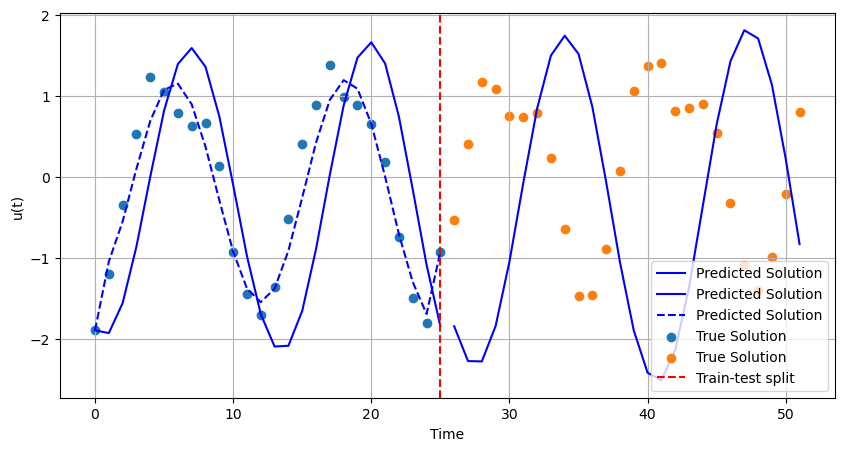

In [185]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_train, y_pred_train[:,0], 'b', label='Predicted Solution')
plt.plot(t_test, y_pred_test[:,0], 'b', label='Predicted Solution')
plt.plot(t_train, u_model[0], 'b--', label='Predicted Solution')

plt.scatter(t_train, Y_train[:,0], label='True Solution')
plt.scatter(t_test, Y_test[:,0], label='True Solution')

#plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=t_train[-1], color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

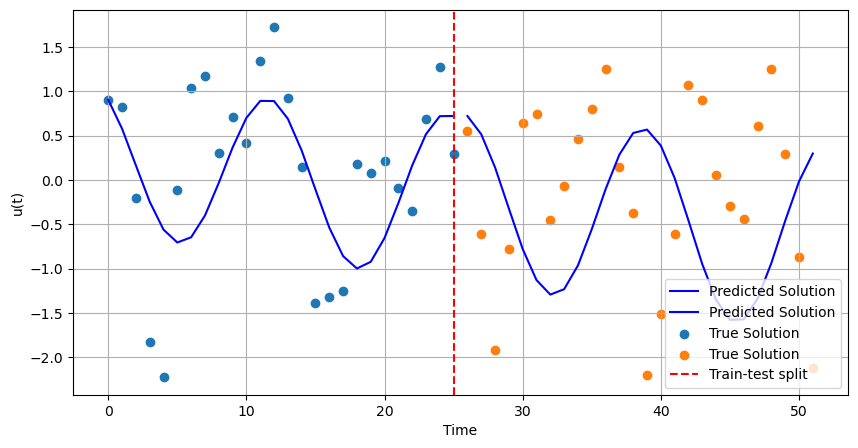

In [177]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_train, y_pred_train[:,1], 'b', label='Predicted Solution')
plt.plot(t_test, y_pred_test[:,1], 'b', label='Predicted Solution')

plt.scatter(t_train, Y_train[:,1], label='True Solution')
plt.scatter(t_test, Y_test[:,1], label='True Solution')

#plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=t_train[-1], color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

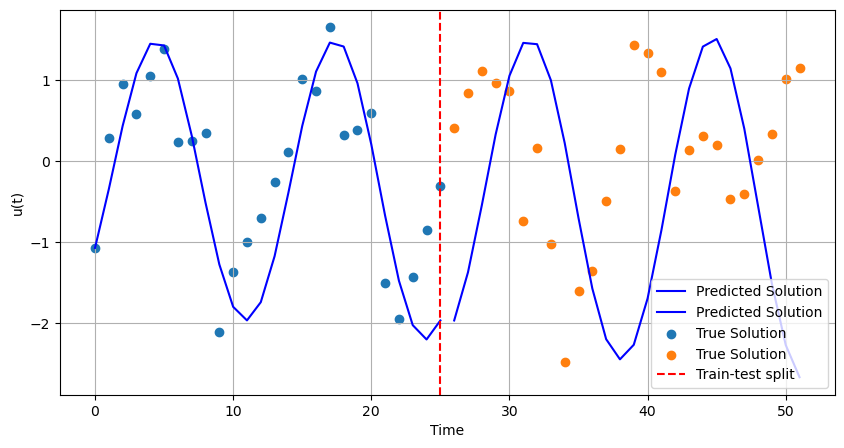

In [178]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_train, y_pred_train[:,2], 'b', label='Predicted Solution')
plt.plot(t_test, y_pred_test[:,2], 'b', label='Predicted Solution')

plt.scatter(t_train, Y_train[:,2], label='True Solution')
plt.scatter(t_test, Y_test[:,2], label='True Solution')

#plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=t_train[-1], color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Test MAE: 1.4620765827106967


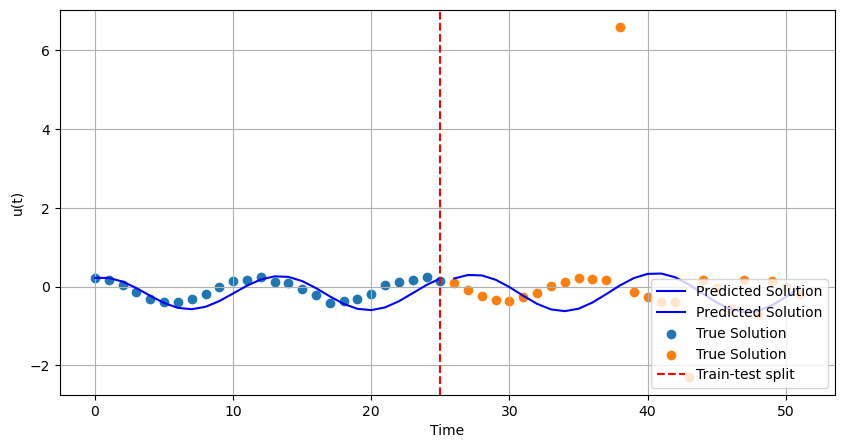

In [179]:
y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test)
mae_test = jnp.mean(jnp.abs(y_pred_test - Y_test))
print (f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_train, y_pred_train[:,3], 'b', label='Predicted Solution')
plt.plot(t_test, y_pred_test[:,3], 'b', label='Predicted Solution')

plt.scatter(t_train, Y_train[:,3], label='True Solution')
plt.scatter(t_test, Y_test[:,3], label='True Solution')

#plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=t_train[-1], color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

----

## `Chebyshev Nodes`

In [588]:
t_train_chebyshev = np.squeeze(np.array(pd.read_csv('../data/daily_climate/train/t_train_chebyshev.csv'), dtype=jnp.float64)) # x is timepoints t
Y_train_chebyshev = np.squeeze(np.array(pd.read_csv('../data/daily_climate/train/Y_train_chebyshev.csv'))) 

t_test_chebyshev = jnp.squeeze(jnp.array(pd.read_csv('../data/daily_climate/test/t_test_chebyshev.csv'), dtype=jnp.float64))
Y_test_chebyshev = jnp.squeeze(jnp.array(pd.read_csv('../data/daily_climate/test/Y_test_chebyshev.csv'))) # y is the mean temperature

In [589]:
n = 200
t_train_chebyshev = t_train_chebyshev[:n]
Y_train_chebyshev = Y_train_chebyshev[:n] #[:,:4]

y_train_chebyshev = np.atleast_2d(Y_train_chebyshev[:,0]).T
x_train_chebyshev = Y_train_chebyshev[:,1:]

y_test = np.atleast_2d(Y_test_chebyshev[:,0]).T
y_test = Y_test_chebyshev[:,1:]

In [590]:
estimated_derivative, estimated_solution = collocate_data(y_train_chebyshev, t_train_chebyshev, 'EpanechnikovKernel', bandwidth=0.1)
estimated_solution = np.atleast_2d(estimated_solution).T

weights = compute_weights(t_train_chebyshev)
D = np.array(lagrange_derivative(t_train_chebyshev, weights))

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [591]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

params = {
    "tol": 1e-6,
    "acceptable_tol": 1e-4,
    "acceptable_iter": 5,
    "acceptable_constr_viol_tol": 1e-4,
    "acceptable_dual_inf_tol": 1e-2,
    "acceptable_compl_inf_tol": 1e-2,
    "mu_strategy": "adaptive",
    "mu_oracle": "probing",
    "mu_init": 0.1,
    "line_search_method": "filter",
    "alpha_red_factor": 0.5,
    "max_soc": 4,
    "hessian_approximation": "limited-memory",
    "limited_memory_max_history": 20,
    "max_hessian_perturbation": 1e2,
    "nlp_scaling_method": "gradient-based",
    "nlp_scaling_max_gradient": 100,
    #"linear_solver": "mumps",
    #"linear_system_scaling": "mc19",
    "max_iter": 3000,
    "max_cpu_time": 1000,
    "diverging_iterates_tol": 1e20,
    "check_derivatives_for_naninf": "yes",
    "derivative_test": "first-order",
    "print_level": 5
}

In [685]:
layer_widths = [5, 50, 4]

# solver.options['print_level'] = 5
params = {"tol":1e-1, "print_level": 5, "hessian_approximation": 'limited-memory', 
          'mu_strategy': 'adaptive', "dual_inf_tol": 1e-1, "constr_viol_tol": 1e-1, "compl_inf_tol": 1e-2,
          "check_derivatives_for_naninf": 'yes'
          }
          #, "expect_infeasible_problem": 'yes', "check_derivatives_for_naninf": 'yes', 'bound_relax_factor': 1e-12}
#  "mu_strategy":"adaptive"
# , 'mu_strategy': 'adaptive'


start_timer_build = time.time()
ode_model = NeuralODEPyomo(Y_train_chebyshev, t_train_chebyshev, D, layer_widths, act_func = "tanh", max_iter = 3000, params = params, penalty_lambda=0.01, w_init_method ="random", time_invariant = False) # , extra_input = t_train
# , y_init = estimated_solution

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
y_model = ode_model.extract_solution().T

HERE
Ipopt 3.14.16: max_iter=3000
halt_on_ampl_error=yes
tol=0.1
print_level=5
hessian_approximation=limited-memory
mu_strategy=adaptive
dual_inf_tol=0.1
constr_viol_tol=0.1
compl_inf_tol=0.01
check_derivatives_for_naninf=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   179784
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      904
                     variables with only lower bounds:   

In [682]:
def find_closest_index(t_train_chebyshev, target_value):
    differences = jnp.abs(t_train_chebyshev - target_value)
    closest_index = jnp.argmin(differences)
    return closest_index

def system_dynamics(y, t, args):
    input = y
    input = jnp.append(y, t)
    
    args, t_points = args
    
    ind = find_closest_index(t_points, t)
    for arg in args[ind]:
        input = jnp.append(input, arg)
    
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])


y_pred_train = odeint(system_dynamics, y_train_chebyshev[0], t_train_chebyshev, (x_train_chebyshev, t_train_chebyshev))
mae_train = jnp.mean(jnp.abs(y_pred_train - y_train_chebyshev))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_chebyshev, (y_test, t_test_chebyshev))
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test))
print (f"Test MAE: {mae_test}")

Train MAE: 0.059090239536659504
Test MAE: 0.47201653860028536


In [ ]:
def find_closest_index(t_train_chebyshev, target_value):
    differences = jnp.abs(t_train_chebyshev - target_value)
    closest_index = jnp.argmin(differences)
    return closest_index

def system_dynamics(y, t, args):
    input = y
    input = jnp.append(y, t)
    
    if args is not None:
        args, t_points = args
        
        ind = find_closest_index(t_points, t)
        for arg in args[ind]:
            input = jnp.append(input, arg)
    
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])


y_pred_train = odeint(system_dynamics, y_train_chebyshev[0], t_train_chebyshev, (x_train_chebyshev, t_train_chebyshev))
mae_train = jnp.mean(jnp.abs(y_pred_train - y_train_chebyshev))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_chebyshev, (y_test, t_test_chebyshev))
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test))
print (f"Test MAE: {mae_test}")

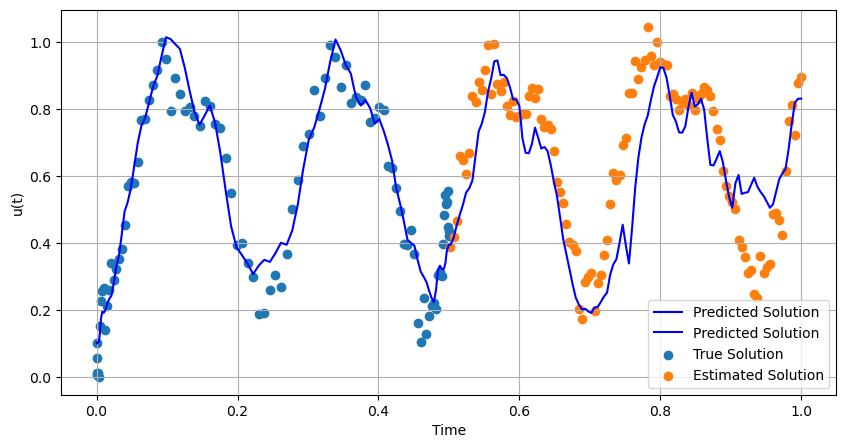

In [683]:
for i in range(1):
    #---------------------------PLOTTING RESULTS--------------------------#
    plt.figure(figsize=(10, 5))
    plt.plot(t_train_chebyshev, y_pred_train[:,i], 'b', label='Predicted Solution')
    plt.plot(t_test, y_pred_test[:,i], 'b', label='Predicted Solution')

    plt.scatter(t_train_chebyshev, Y_train_chebyshev[:,i], label='True Solution')
    plt.scatter(t_test_chebyshev, Y_test_chebyshev[:,i], label='Estimated Solution')

    #plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.show()